In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import glob
import json
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import gamma
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Personal imports
sys.path.append("{}/../../../../utils".format(os.getcwd()))
from surface_utils import load_surface, make_surface_image
from maths_utils import weighted_regression, bootstrap_ci_mean, bootstrap_ci_median
from plot_utils import * 
from pycortex_utils import get_rois, set_pycortex_config_file


In [2]:
with open('../../../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
prf_task_name = analysis_info["prf_task_name"]
rois = analysis_info['rois']
maps_names_css = analysis_info['maps_names_css']
maps_names_pcm = analysis_info['maps_names_pcm']
maps_names_css_stats = analysis_info['maps_names_css_stats']
maps_names_vert_area = analysis_info["maps_names_vert_area"]
maps_names = maps_names_css + maps_names_pcm + maps_names_css_stats + maps_names_vert_area

In [3]:
main_dir = '/Users/uriel/disks/meso_shared'
code_dir = '/Users/uriel/disks/meso_H/projects'
project_dir = 'RetinoMaps'
subject = 'sub-03'
hemi = 'hemi-L'
format_ = 'fsnative'
extension = 'func.gii'

pcm_idx, n_neighbor_idx, vert_geo_dist_avg_idx, vert_prf_dist_idx = 0,1,2,3

rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx, size_idx = 0, 1, 2, 3, 4
amp_idx, baseline_idx, x_idx, y_idx, hrf_1_idx = 5, 6, 7, 8, 9
hrf_2_idx, n_idx, loo_rsq_idx = 10, 11, 12

In [ ]:
derivs_dir = '{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives'.format(main_dir, project_dir,subject,format_)
bold_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_avg'.format(main_dir, project_dir,subject,format_)

pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm-loo-avg_css.{}'.format(derivs_dir,subject, prf_task_name, hemi, extension)
prf_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-deriv-loo-avg_css.{}'.format(derivs_dir,subject, prf_task_name, hemi, extension)
bold_fn = '{}/{}_task-{}_{}_fmriprep_dct_avg_bold.{}'.format(bold_dir,subject, prf_task_name, hemi, extension)

In [ ]:
pcm_img, pcm_data = load_surface(fn=pcm_fn)
prf_img, prf_data = load_surface(fn=prf_fn)

bold_img, bold_data = load_surface(fn=bold_fn)

Objectif : 
We observe some vertex with a very high pcm, we need to understand why. 
pcm = dist geo / dist prf 
dist geo is stable, variation are on dist prf 

# find vertex with small prf distances

observations shows that some vertex have very smalls avg prf distance with neighboor. The r2 of this vertex is good. the present idea is to check if there times series is ok

In [ ]:
smallest_10_indices = np.argpartition(pcm_data[vert_prf_dist_idx], 10)[:10]

In [ ]:
smallest_10_indices

In [ ]:
# plot best voxel for left hemisphere
# max_indices = np.nanargmax(prf_fit_data[r2_idx,:])
num_vert = 4046


fig = go.Figure()
# plot data time series
fig.add_trace(go.Scatter(y=bold_data[:,num_vert],
                         name='data', 
                         mode='markers', 
                          line=dict(color='black') 
                         ))

fig.update_layout(template='simple_white', 
                   # title = '{} vertex time series for {} noise model'.format(num_vert,noise_model_2), 
                   xaxis_title = 'TRs', 
                   yaxis_title = 'z-score', 
                   showlegend= True,
                   height=350, 
                   yaxis=dict(title_standoff=0))

fig.update_xaxes(range=[0,bold_data.shape[0]])


fig.update_yaxes(range=[-4,4])
# fig1.write_image('/Users/uriel/Downloads/sdfr.pdf', width=600, height=300)

fig.show()

==> Time series of the 10 vertex with the smallest prf avg distance is very ok 

# ECC pcm relation

##  all rad

In [ ]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

In [ ]:
colors_rgb

In [ ]:
# Settings
# Figure settings
fig_width = 1440
fig_height = 600
# colormap_dict = {'V1': (243, 231, 155),
#                  'V2': (250, 196, 132),
#                  'V3': (248, 160, 126),
#                  'V3AB': (235, 127, 134),
#                  'LO': (150, 0, 90), 
#                  'VO': (0, 0, 200),
#                  'hMT+': (0, 25, 255),
#                  'iIPS': (0, 152, 255),
#                  'sIPS': (44, 255, 150),
#                  'iPCS': (151, 255, 0),
#                  'sPCS': (255, 234, 0),
#                  'mPCS': (255, 111, 0)
#                 }
# roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]
# plot_groups = [['V1', 'V2', 'V3'], ['V3AB', 'LO', 'VO'], ['hMT+', 'iIPS', 'sIPS'], ['iPCS', 'sPCS', 'mPCS']]
colors_hex = px.colors.qualitative.Plotly

# Fonction pour convertir hex en RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return 'rgb({}, {}, {})'.format(int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16))

# Conversion de la liste
roi_colors = [hex_to_rgb(color) for color in colors_hex]
plot_groups = [['V1'],['V2'],['V3']]
# vert_dist_th_list = [3,8,13,21,34]
vert_dist_th_list = [1,2,3,5,8,13,21,34,55]
# vert_dist_th_list = [34]
num_ecc_pcm_bins = 6
max_ecc = 15


# Define directories and fn
prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, subject, format_)
prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)
vert_area_dir = "{}/{}/derivatives/pp_data/{}/{}/vertex_area".format(main_dir, project_dir, subject, format_)

# General settings
rows, cols = 1, len(plot_groups)
fig = make_subplots(rows=rows, cols=cols, print_grid=False)
for i, vert_dist_th in enumerate(vert_dist_th_list):
    showlegend = True
    
    # global TSV
    #-----------
    # Load all data
    df_rois = pd.DataFrame()
    
    for hemi in ['hemi-L', 'hemi-R']:

        # Derivatives
        deriv_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-deriv-loo-avg_css.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi)
        deriv_img, deriv_mat = load_surface(deriv_avg_fn)

        # pcm
        pcm_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi,vert_dist_th)
        pcm_img, pcm_mat = load_surface(pcm_avg_fn)

        # Stats
        stats_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_loo-avg_prf-stats.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi)
        stats_img, stats_mat = load_surface(stats_avg_fn)

        # Vertex area
        vertex_area_fn = '{}/{}_{}_vertex_area.func.gii'.format(vert_area_dir, subject, hemi)
        vertex_area_img, vertex_area_mat = load_surface(vertex_area_fn)

        # Combine all derivatives
        all_deriv_mat = np.concatenate((deriv_mat, pcm_mat, stats_mat, vertex_area_mat))

        # Get roi mask
        roi_verts = get_rois(subject=subject, 
                             return_concat_hemis=False, 
                             return_hemi=hemi, 
                             rois=rois,
                             mask=True, 
                             atlas_name=None, 
                             surf_size=None)

        # Create and combine pandas df for each roi and brain hemisphere
        for roi in roi_verts.keys():
            data_dict = {col: all_deriv_mat[col_idx, roi_verts[roi]] for col_idx, col in enumerate(maps_names)}
            data_dict['roi'] = np.array([roi] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            data_dict['subject'] = np.array([subject] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            data_dict['hemi'] = np.array([hemi] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            df_rois = pd.concat([df_rois, pd.DataFrame(data_dict)], ignore_index=True)
                
    # pcm TSV
    #-----------
    data = df_rois
    data_pcm = data
    ecc_bins = np.concatenate(([0],np.linspace(0.4, 1, num_ecc_pcm_bins)**2 * max_ecc))

    for num_roi, roi in enumerate(rois):
        df_roi = data_pcm.loc[(data.roi == roi)]
        df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
        df_ecc_pcm_bin = pd.DataFrame()
        df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
        df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
        df_ecc_pcm_bin['prf_ecc_bins'] = np.array(df_bins['prf_ecc'].mean())
        df_ecc_pcm_bin['prf_pcm_bins_mean'] = np.array(df_bins['pcm'].mean())
        df_ecc_pcm_bin['prf_loo_r2_bins_mean'] = np.array(df_bins['prf_loo_r2'].mean())
        ci = df_bins['pcm'].apply(lambda x: bootstrap_ci_mean(x))
        df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = np.array(ci.apply(lambda x: x[1] if not np.isnan(x[1]) else np.nan))
        df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = np.array(ci.apply(lambda x: x[0] if not np.isnan(x[0]) else np.nan))
        if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
        else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])

    df_ecc_pcm = df_ecc_pcm_bins
    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # # General settings
    # rows, cols = 1, len(plot_groups)
    # fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            # roi_color = roi_colors[j + l * 3]
            roi_color = roi_colors[i]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_mean = np.array(df.prf_ecc_bins)
            pcm_mean = np.array(df.prf_pcm_bins_mean)
            r2_mean = np.array(df.prf_loo_r2_bins_mean)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_mean, pcm_mean, r2_mean, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_mean[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_mean[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_mean[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_mean[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_mean[0], ecc_mean[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_mean, 
                                     y=pcm_mean, 
                                     mode='markers', 
                                     name='{} rad'.format(vert_dist_th),
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_mean, 
                                                  arrayminus=pcm_mean - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=showlegend), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=max_ecc-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_ecc], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=True, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)

In [ ]:
fig.show()

## 30 rad mean

In [ ]:
# Settings
# Figure settings
fig_width = 1440
fig_height = 600
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]
plot_groups = [['V1', 'V2', 'V3'], ['V3AB', 'LO', 'VO'], ['hMT+', 'iIPS', 'sIPS'], ['iPCS', 'sPCS', 'mPCS']]
# vert_dist_th_list = [3,8,13,21,34]
# vert_dist_th_list = [1,2,3,5,8,13,21,34,55]
vert_dist_th_list = [34]
num_ecc_pcm_bins = 6
max_ecc = 15

# Threshold settings
ecc_threshold = analysis_info['ecc_th']
size_threshold = analysis_info['size_th']
rsqr_threshold = analysis_info['rsqr_th']
pcm_threshold = analysis_info['pcm_th']
amplitude_threshold = analysis_info['amplitude_th']
stats_threshold = analysis_info['stats_th']
n_threshold = analysis_info['n_th']

# Define directories and fn
prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, subject, format_)
prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)
vert_area_dir = "{}/{}/derivatives/pp_data/{}/{}/vertex_area".format(main_dir, project_dir, subject, format_)

# General settings
rows, cols = 1, len(plot_groups)
fig = make_subplots(rows=rows, cols=cols, print_grid=False)
for i, vert_dist_th in enumerate(vert_dist_th_list):
    showlegend = True
    
    # global TSV
    #-----------
    # Load all data
    df_rois = pd.DataFrame()
    
    for hemi in ['hemi-L', 'hemi-R']:

        # Derivatives
        deriv_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-deriv-loo-avg_css.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi)
        deriv_img, deriv_mat = load_surface(deriv_avg_fn)

        # pcm
        pcm_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi,vert_dist_th)
        pcm_img, pcm_mat = load_surface(pcm_avg_fn)

        # Stats
        stats_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_loo-avg_prf-stats.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi)
        stats_img, stats_mat = load_surface(stats_avg_fn)

        # Vertex area
        vertex_area_fn = '{}/{}_{}_vertex_area.func.gii'.format(vert_area_dir, subject, hemi)
        vertex_area_img, vertex_area_mat = load_surface(vertex_area_fn)

        # Combine all derivatives
        all_deriv_mat = np.concatenate((deriv_mat, pcm_mat, stats_mat, vertex_area_mat))

        # Get roi mask
        roi_verts = get_rois(subject=subject, 
                             return_concat_hemis=False, 
                             return_hemi=hemi, 
                             rois=rois,
                             mask=True, 
                             atlas_name=None, 
                             surf_size=None)

        # Create and combine pandas df for each roi and brain hemisphere
        for roi in roi_verts.keys():
            data_dict = {col: all_deriv_mat[col_idx, roi_verts[roi]] for col_idx, col in enumerate(maps_names)}
            data_dict['roi'] = np.array([roi] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            data_dict['subject'] = np.array([subject] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            data_dict['hemi'] = np.array([hemi] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            df_rois = pd.concat([df_rois, pd.DataFrame(data_dict)], ignore_index=True)
                
    # pcm TSV
    #-----------
    data = df_rois
    
    
    # Threshold data (replace by nan)
    #---------------------------------
    if stats_threshold == 0.05: stats_col = 'corr_pvalue_5pt'
    elif stats_threshold == 0.01: stats_col = 'corr_pvalue_1pt'
    data.loc[(data.amplitude < amplitude_threshold) |
             (data.prf_ecc < ecc_threshold[0]) | (data.prf_ecc > ecc_threshold[1]) |
             (data.prf_size < size_threshold[0]) | (data.prf_size > size_threshold[1]) | 
             (data.prf_n < n_threshold[0]) | (data.prf_n > n_threshold[1]) | 
             (data.prf_loo_r2 < rsqr_threshold) |
             (data[stats_col] > stats_threshold)] = np.nan
    data = data.dropna()
    data_pcm = data
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    ecc_bins = np.concatenate(([0],np.linspace(0.4, 1, num_ecc_pcm_bins)**2 * max_ecc))

    for num_roi, roi in enumerate(rois):
        df_roi = data_pcm.loc[(data.roi == roi)]
        df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
        df_ecc_pcm_bin = pd.DataFrame()
        df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
        df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
        df_ecc_pcm_bin['prf_ecc_bins'] = np.array(df_bins['prf_ecc'].mean())
        df_ecc_pcm_bin['prf_pcm_bins_mean'] = np.array(df_bins['pcm'].mean())
        df_ecc_pcm_bin['prf_loo_r2_bins_mean'] = np.array(df_bins['prf_loo_r2'].mean())
        ci = df_bins['pcm'].apply(lambda x: bootstrap_ci_mean(x))
        df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = np.array(ci.apply(lambda x: x[1] if not np.isnan(x[1]) else np.nan))
        df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = np.array(ci.apply(lambda x: x[0] if not np.isnan(x[0]) else np.nan))
        if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
        else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])

    df_ecc_pcm = df_ecc_pcm_bins
    

    # Figure
    #-----------
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # # General settings
    # rows, cols = 1, len(plot_groups)
    # fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[j + l * 3]
            
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_mean = np.array(df.prf_ecc_bins)
            pcm_mean = np.array(df.prf_pcm_bins_mean)
            r2_mean = np.array(df.prf_loo_r2_bins_mean)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_mean, pcm_mean, r2_mean, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_mean[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_mean[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_mean[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_mean[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_mean[0], ecc_mean[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # # Error area
            # fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
            #                           y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
            #                           mode='lines', fill='toself', fillcolor=roi_color_opac, 
            #                           line=dict(color=roi_color_opac, width=0), showlegend=False), 
            #               row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_mean, 
                                     y=pcm_mean, 
                                     mode='markers', 
                                     name='{} rad'.format(vert_dist_th),
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_mean, 
                                                  arrayminus=pcm_mean - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=showlegend), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=max_ecc-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_ecc], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)

In [ ]:
fig.show()
fig.write_image('/Users/uriel/Downloads/{}_ecc_pcm_{}_mean.pdf'.format(subject,vert_dist_th), width=1440, height=300)

## 30 rad median 

In [36]:
# Settings
# Figure settings
fig_width = 1440
fig_height = 600
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]
plot_groups = [['V1', 'V2', 'V3'], ['V3AB', 'LO', 'VO'], ['hMT+', 'iIPS', 'sIPS'], ['iPCS', 'sPCS', 'mPCS']]
# vert_dist_th_list = [3,8,13,21,34]
# vert_dist_th_list = [1,2,3,5,8,13,21,34,55]
vert_dist_th_list = [34]
num_ecc_pcm_bins = 6
max_ecc = 20

# Threshold settings
ecc_threshold = analysis_info['ecc_th']
size_threshold = analysis_info['size_th']
rsqr_threshold = analysis_info['rsqr_th']
pcm_threshold = analysis_info['pcm_th']
amplitude_threshold = analysis_info['amplitude_th']
stats_threshold = analysis_info['stats_th']
n_threshold = analysis_info['n_th']

# Define directories and fn
prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, subject, format_)
prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)
vert_area_dir = "{}/{}/derivatives/pp_data/{}/{}/vertex_area".format(main_dir, project_dir, subject, format_)

# General settings
rows, cols = 1, len(plot_groups)
fig = make_subplots(rows=rows, cols=cols, print_grid=False)
for i, vert_dist_th in enumerate(vert_dist_th_list):
    showlegend = True
    
    # global TSV
    #-----------
    # Load all data
    df_rois = pd.DataFrame()
    
    for hemi in ['hemi-L', 'hemi-R']:

        # Derivatives
        deriv_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-deriv-loo-avg_css.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi)
        deriv_img, deriv_mat = load_surface(deriv_avg_fn)

        # pcm
        pcm_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}_median-loo-avg_css.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi, vert_dist_th)
        pcm_img, pcm_mat = load_surface(pcm_avg_fn)

        # Stats
        stats_avg_fn = '{}/{}_task-{}_{}_fmriprep_dct_loo-avg_prf-stats.func.gii'.format(
            prf_deriv_dir, subject, prf_task_name, hemi)
        stats_img, stats_mat = load_surface(stats_avg_fn)

        # Vertex area
        vertex_area_fn = '{}/{}_{}_vertex_area.func.gii'.format(vert_area_dir, subject, hemi)
        vertex_area_img, vertex_area_mat = load_surface(vertex_area_fn)

        # Combine all derivatives
        all_deriv_mat = np.concatenate((deriv_mat, pcm_mat, stats_mat, vertex_area_mat))

        # Get roi mask
        roi_verts = get_rois(subject=subject, 
                             return_concat_hemis=False, 
                             return_hemi=hemi, 
                             rois=rois,
                             mask=True, 
                             atlas_name=None, 
                             surf_size=None)

        # Create and combine pandas df for each roi and brain hemisphere
        for roi in roi_verts.keys():
            data_dict = {col: all_deriv_mat[col_idx, roi_verts[roi]] for col_idx, col in enumerate(maps_names)}
            data_dict['roi'] = np.array([roi] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            data_dict['subject'] = np.array([subject] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            data_dict['hemi'] = np.array([hemi] * all_deriv_mat[:, roi_verts[roi]].shape[1])
            df_rois = pd.concat([df_rois, pd.DataFrame(data_dict)], ignore_index=True)
                
    # pcm TSV
    #-----------
    data = df_rois
    
    
    # Threshold data (replace by nan)
    #---------------------------------
    if stats_threshold == 0.05: stats_col = 'corr_pvalue_5pt'
    elif stats_threshold == 0.01: stats_col = 'corr_pvalue_1pt'
    data.loc[(data.amplitude < amplitude_threshold) |
             (data.prf_ecc < ecc_threshold[0]) | (data.prf_ecc > ecc_threshold[1]) |
             (data.prf_size < size_threshold[0]) | (data.prf_size > size_threshold[1]) | 
             (data.prf_n < n_threshold[0]) | (data.prf_n > n_threshold[1]) | 
             (data.prf_loo_r2 < rsqr_threshold) |
             (data[stats_col] > stats_threshold)] = np.nan
    data = data.dropna()
    data_pcm = data
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    ecc_bins = np.concatenate(([0],np.linspace(0.4, 1, num_ecc_pcm_bins)**2 * max_ecc))

    for num_roi, roi in enumerate(rois):
        df_roi = data_pcm.loc[(data.roi == roi)]
        df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
        df_ecc_pcm_bin = pd.DataFrame()
        df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
        df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
        df_ecc_pcm_bin['prf_ecc_bins'] = np.array(df_bins['prf_ecc'].median())
        df_ecc_pcm_bin['prf_pcm_bins_mean'] = np.array(df_bins['pcm'].median())
        df_ecc_pcm_bin['prf_loo_r2_bins_mean'] = np.array(df_bins['prf_loo_r2'].median())
        
        df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = df_bins['pcm'].apply(lambda x: np.percentile(x, 75)).values
        df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = df_bins['pcm'].apply(lambda x: np.percentile(x, 25)).values 
        
        if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
        else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])

    df_ecc_pcm = df_ecc_pcm_bins
    

    # Figure
    #-----------
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # # General settings
    # rows, cols = 1, len(plot_groups)
    # fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[j + l * 3]
            
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_mean = np.array(df.prf_ecc_bins)
            pcm_mean = np.array(df.prf_pcm_bins_mean)
            r2_mean = np.array(df.prf_loo_r2_bins_mean)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_mean, pcm_mean, r2_mean, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_mean[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_mean[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_mean[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_mean[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_mean[0], ecc_mean[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_mean, 
                                     y=pcm_mean, 
                                     mode='markers', 
                                     name='{} rad'.format(vert_dist_th),
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_mean, 
                                                  arrayminus=pcm_mean - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=showlegend), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=max_ecc-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_ecc], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)

In [33]:
df_bins

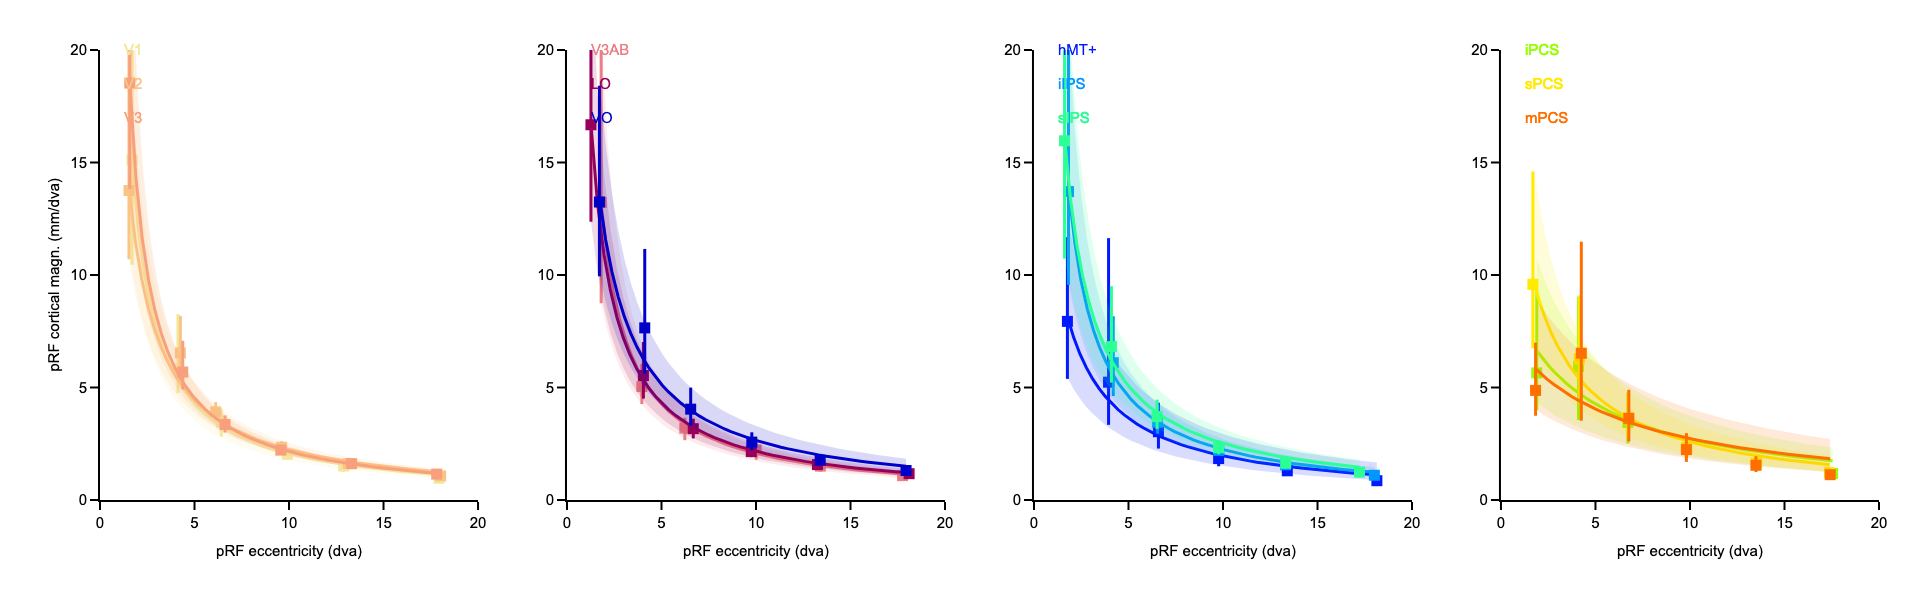

In [37]:
fig.show()
fig.write_image('/Users/uriel/Downloads/{}_ecc_pcm_{}_median.pdf'.format(subject,vert_dist_th), width=1440, height=300)

# ecc pcm relation

In [ ]:
tsv_dir = '{}/{}/derivatives/pp_data/{}/{}/prf/tsv'.format(
    main_dir, project_dir, subject, format_)
os.makedirs(tsv_dir, exist_ok=True)

tsv_fn = '{}/{}_css-all_derivatives.tsv'.format(tsv_dir, subject)
data = pd.read_table(tsv_fn, sep="\t")

In [ ]:
roi = 'VO'
df_roi = data_pcm.loc[(data.roi == roi)]
Q1 = df_roi.pcm.quantile(0.25)
Q3 = df_roi.pcm.quantile(0.75)
IQR = Q3 - Q1

# Détection des outliers
outliers = df_roi.pcm[(df_roi.pcm < Q1 - 1.5 * IQR) | (df_roi.pcm > Q3 + 1.5 * IQR)]

In [ ]:
outliers

In [ ]:
data_pcm = data
num_ecc_pcm_bins = 10
max_ecc = 15
ecc_bins = np.concatenate(([0],np.linspace(0.4, 1, num_ecc_pcm_bins)**2 * max_ecc))

for num_roi, roi in enumerate(rois):
    df_roi = data_pcm.loc[(data.roi == roi)]
    df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
    df_ecc_pcm_bin = pd.DataFrame()
    df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
    df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
    df_ecc_pcm_bin['prf_ecc_bins'] = np.array(df_bins['prf_ecc'].mean())
    df_ecc_pcm_bin['prf_pcm_bins_mean'] = np.array(df_bins['pcm'].mean())
    df_ecc_pcm_bin['prf_loo_r2_bins_mean'] = np.array(df_bins['prf_loo_r2'].mean())
    ci = df_bins['pcm'].apply(lambda x: bootstrap_ci_mean(x))
    df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = np.array(ci.apply(lambda x: x[1] if not np.isnan(x[1]) else np.nan))
    df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = np.array(ci.apply(lambda x: x[0] if not np.isnan(x[0]) else np.nan))
    if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
    else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])

df_ecc_pcm = df_ecc_pcm_bins

In [ ]:
# Figure settings
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]
plot_groups = [['V1', 'V2', 'V3']]
num_ecc_size_bins = 6
num_ecc_pcm_bins = 6
num_polar_angle_bins = 9
max_ecc = 15
screen_side = 20
gaussian_mesh_grain = 100
hot_zone_percent = 0.01
fig_width = 1440

In [ ]:
fig = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm, fig_width=fig_width, fig_height=400, 
                        rois=rois, roi_colors=roi_colors,
                        plot_groups=plot_groups, max_ecc=max_ecc)
fig.write_image('/Users/uriel/Downloads/{}_pcm_ecc.pdf'.format(subject), width=1440, height=300)

In [ ]:
fig.show()

In [ ]:
pcm_std = data.pcm.std()

In [ ]:
# Threshold settings
ecc_threshold = analysis_info['ecc_th']
size_threshold = analysis_info['size_th']
rsqr_threshold = analysis_info['rsqr_th']
pcm_threshold = analysis_info['pcm_th']
amplitude_threshold = analysis_info['amplitude_th']
stats_threshold = analysis_info['stats_th']
n_threshold = analysis_info['n_th']
# subjects = analysis_info['subjects']

# Threshold data (replace by nan)
if stats_threshold == 0.05: stats_col = 'corr_pvalue_5pt'
elif stats_threshold == 0.01: stats_col = 'corr_pvalue_1pt'
data.loc[(data.amplitude < amplitude_threshold) |
         (data.prf_ecc < ecc_threshold[0]) | (data.prf_ecc > ecc_threshold[1]) |
         (data.prf_size < size_threshold[0]) | (data.prf_size > size_threshold[1]) | 
         (data.prf_n < n_threshold[0]) | (data.prf_n > n_threshold[1]) | 
         # (data.pcm < pcm_threshold[0]) | (data.pcm > pcm_threshold[1]) |
         # (data.pcm < Q1 - 1.5 * IQR) | (data.pcm > Q3 + 1.5 * IQR) |
         (data.prf_loo_r2 < rsqr_threshold) |
         (data[stats_col] > stats_threshold)] = np.nan
data = data.dropna()

# outliers detection for each rois
for roi in rois:
    Q1 = data.loc[data.roi == roi, 'pcm'].quantile(0.25)
    Q3 = data.loc[data.roi == roi, 'pcm'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data.loc[data.roi == roi, 'pcm'] < Q1 - 1.5 * IQR) | (data.loc[data.roi == roi, 'pcm'] > Q3 + 1.5 * IQR)
    data.loc[(data.roi == roi) & outliers, 'pcm'] = np.nan    
data = data.dropna()

In [ ]:
data_pcm = data
num_ecc_pcm_bins = 6
max_ecc = 20
ecc_bins = np.concatenate(([0],np.linspace(0.1, 1, num_ecc_pcm_bins)**2 * max_ecc))

for num_roi, roi in enumerate(rois):
    df_roi = data_pcm.loc[(data.roi == roi)]
    df_bins = df_roi.groupby(pd.cut(df_roi['prf_ecc'], bins=ecc_bins))
    df_ecc_pcm_bin = pd.DataFrame()
    df_ecc_pcm_bin['roi'] = [roi]*num_ecc_pcm_bins
    df_ecc_pcm_bin['num_bins'] = np.arange(num_ecc_pcm_bins)
    df_ecc_pcm_bin['prf_ecc_bins'] = np.array(df_bins['prf_ecc'].mean())
    df_ecc_pcm_bin['prf_pcm_bins_mean'] = np.array(df_bins['pcm'].mean())
    df_ecc_pcm_bin['prf_loo_r2_bins_mean'] = np.array(df_bins['prf_loo_r2'].mean())
    ci = df_bins['pcm'].apply(lambda x: bootstrap_ci_mean(x))
    df_ecc_pcm_bin['prf_pcm_bins_ci_upper_bound'] = np.array(ci.apply(lambda x: x[1] if not np.isnan(x[1]) else np.nan))
    df_ecc_pcm_bin['prf_pcm_bins_ci_lower_bound'] = np.array(ci.apply(lambda x: x[0] if not np.isnan(x[0]) else np.nan))
    if num_roi == 0: df_ecc_pcm_bins = df_ecc_pcm_bin
    else: df_ecc_pcm_bins = pd.concat([df_ecc_pcm_bins, df_ecc_pcm_bin])

df_ecc_pcm = df_ecc_pcm_bins

In [ ]:
ecc_bins = np.concatenate(([0],np.linspace(0.2, 1, num_ecc_pcm_bins)**2 * max_ecc))

In [ ]:
ecc_bins

In [ ]:
fig = prf_ecc_pcm_plot(df_ecc_pcm=df_ecc_pcm, fig_width=fig_width, fig_height=400, 
                        rois=rois, roi_colors=roi_colors,
                        plot_groups=plot_groups, max_ecc=max_ecc)
fig.write_image('/Users/uriel/Downloads/{}_pcm_ecc_th.pdf'.format(subject), width=1440, height=300)

In [ ]:
fig.show()


In [ ]:
# Figure settings
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]
# vert_dist_th_list = [1,2,3,5,8,13,21,34]
vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, roi in enumerate(rois):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    df_roi = data.loc[data.roi == roi]

    fig.add_trace(go.Box(

        
        y = df_roi.pcm,
        legendgroup=roi,
        name='{}'.format(roi),
        showlegend=False,
        notched=False,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line_color='rgba(0,0,0,0)',
        fillcolor='rgba(0,0,0,0)',
        marker_color=roi_colors[j],
        marker_opacity=0.4))






# fig.update_yaxes(title='pcm', range=[0,200])
fig.update_yaxes(title='pcm')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_distribution.pdf'.format(subject), width=1440, height=300)
fig.show()

In [ ]:
# Figure settings
colormap_dict = {'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)
                }
roi_colors = ['rgb({},{},{})'.format(*rgb) for rgb in colormap_dict.values()]
# vert_dist_th_list = [1,2,3,5,8,13,21,34]
vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, roi in enumerate(rois):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    df_roi = data.loc[data.roi == roi]

    fig.add_trace(go.Box(

        
        y = df_roi.pcm,
        legendgroup=roi,
        name='{}'.format(roi),
        showlegend=False,
        notched=False,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line_color='rgba(0,0,0,0)',
        fillcolor='rgba(0,0,0,0)',
        marker_color=roi_colors[j],
        marker_opacity=0.4))






# fig.update_yaxes(title='pcm', range=[0,200])
fig.update_yaxes(title='pcm')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_distribution.pdf'.format(subject), width=1440, height=300)
fig.show()

# pcm prf distance

In [ ]:
vert_dist_th_list = [1,2,3,5,8,13,21,34]
# vert_dist_th_list = [1,2,3]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for i, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    
    fig.add_trace(go.Scatter(
        x=pcm_data[vert_prf_dist_idx],
        y=pcm_data[pcm_idx], 
        mode='markers',
        marker=dict(color=colors[i % len(colors)]),  
        name='{} rad'.format(vert_dist_th),
        showlegend =True,
    ))
fig.update_xaxes(range=[1,20], title='mean neighbor prf distance')
fig.update_yaxes(range=[0,20], title='pcm')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_prf_distance.pdf'.format(subject), width=1440, height=300)
fig.show()

# pcm distribution

In [ ]:
vert_dist_th_list = [1,2,3,5,8,13,21,34,55]
# vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    

    fig.add_trace(go.Box(

        y=pcm_data[pcm_idx],
        # y = data.pcm,
        legendgroup=vert_dist_th,
        name='{} rad'.format(vert_dist_th),
        showlegend=False,
        notched=False,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line_color='rgba(0,0,0,0)',
        fillcolor='rgba(0,0,0,0)',
        marker_color=colors[j],
        marker_opacity=0.4))
    
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmean(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color=colors[j]),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmedian(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color='black'),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))





# fig.update_yaxes(title='pcm', range=[0,200])
fig.update_yaxes(title='pcm')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_distribution.pdf'.format(subject), width=1440, height=300)
fig.show()

# Mean pcm 

In [ ]:
# vert_dist_th_list = [1,2,3,5,8,13,21]
vert_dist_th_list = [1,2,3,5,8,13,21,34,55]
fig = go.Figure()
for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    
    # Calculate mean and standard deviation
    mean_val_prf = np.nanmean(pcm_data[pcm_idx])
    std_val_prf = np.nanstd(pcm_data[pcm_idx])

    
    # Add scatter plot for mean values with error bars representing standard deviation
    fig.add_trace(go.Scatter(
        x=['{} rad'.format(vert_dist_th)],
        y=[mean_val_prf],
        error_y=dict(type='data', array=[std_val_prf], visible=True),
        mode='markers',
        marker=dict(color=colors[j]),
        name='{} rad'.format(vert_dist_th)
    ))


# Update y-axis title
fig.update_yaxes(title='pcm')

# Update layout
fig.update_layout(template='simple_white')

# Show the figure
fig.show()

In [ ]:
vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    

    fig.add_trace(go.Box(

        y=pcm_data[vert_prf_dist_idx],
        legendgroup=vert_dist_th,
        name='{} rad'.format(vert_dist_th),
        showlegend=False,
        notched=False,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line_color='rgba(0,0,0,0)',
        fillcolor='rgba(0,0,0,0)',
        marker_color=colors[j],
        marker_opacity=0.4))
    
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmean(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color=colors[j]),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmedian(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color='black'),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))





fig.update_yaxes(title='mean neighbor prf distance')
# fig.update_yaxes(title='vert_prf_dist')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_distribution.pdf'.format(subject), width=1440, height=300)
fig.show()

In [ ]:
fig = go.Figure()
for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    
    # Calculate mean and standard deviation
    mean_val_prf = np.nanmean(pcm_data[vert_prf_dist_idx])
    std_val_prf = np.nanstd(pcm_data[vert_prf_dist_idx])
    mean_val_geo = np.nanmean(pcm_data[vert_geo_dist_avg_idx])
    std_val_geo = np.nanstd(pcm_data[vert_geo_dist_avg_idx])
    
    # Add scatter plot for mean values with error bars representing standard deviation
    fig.add_trace(go.Scatter(
        x=['{} rad'.format(vert_dist_th)],
        y=[mean_val_prf],
        error_y=dict(type='data', array=[std_val_prf], visible=True),
        mode='markers',
        marker=dict(color=colors[j]),
        name='{} rad'.format(vert_dist_th)
    ))
    fig.add_trace(go.Scatter(
        x=['{} rad'.format(vert_dist_th+0.1)],
        y=[mean_val_geo],
        error_y=dict(type='data', array=[std_val_geo], visible=True),
        mode='markers',
        marker=dict(color=colors[j], symbol='square'),
        name='{} rad'.format(vert_dist_th)
    ))

# Update y-axis title
fig.update_yaxes(title='mean neighbor prf distance')

# Update layout
fig.update_layout(template='simple_white')

# Show the figure
fig.show()

In [ ]:
vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    

    fig.add_trace(go.Box(

        y=pcm_data[vert_geo_dist_avg_idx],
        legendgroup=vert_dist_th,
        name='{} rad'.format(vert_dist_th),
        showlegend=False,
        notched=False,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line_color='rgba(0,0,0,0)',
        fillcolor='rgba(0,0,0,0)',
        marker_color=colors[j],
        marker_opacity=0.4))
    
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmean(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color=colors[j]),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmedian(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color='black'),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))





fig.update_yaxes(title='mean neighbor geo distance')
# fig.update_yaxes(title='vert_prf_dist')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_distribution.pdf'.format(subject), width=1440, height=300)
fig.show()

In [ ]:
vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    

    fig.add_trace(go.Scatter(
        x=[vert_dist_th],
        y=[np.mean(pcm_data[pcm_idx])],
        mode='markers',
        marker=dict(color=colors[j % len(colors)], size=10),  # Choisir une couleur et taille des points
        name=f'vert_dist_th: {vert_dist_th}'
    ))






# fig.update_yaxes(title='pcm', range=[0,2])
fig.update_yaxes(title='pcm')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_mean_median.pdf'.format(subject), width=1440, height=300)
fig.show()

In [ ]:
vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

# Ajouter les histogrammes pour chaque valeur de vert_dist_th
for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)

    fig.add_trace(go.Histogram(
        x=pcm_data[vert_prf_dist_idx],
        name='{} rad'.format(vert_dist_th),
        marker_color=colors[j % len(colors)],
        opacity=0.75
    ))

# Mettre à jour les axes et la mise en page de la figure
fig.update_yaxes(title='Count')
fig.update_xaxes(title='vert_prf_dist', range=[0,5])
fig.update_layout(
    barmode='overlay',
    template='simple_white',

    legend_title='vert_dist_th'
)
fig.show()

In [ ]:
# vert_dist_th_list = [1,2,3,5,8,13,21]
vert_dist_th_list = [1,2,3,5]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for i, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    
    fig.add_trace(go.Violin(y=pcm_data[pcm_idx], 
                            name='{} rad'.format(vert_dist_th),
                            points= 'all',
                            # box_visible=True,

                            meanline_visible=True))



# fig.update_yaxes(title='pcm', range=[0,100])
fig.update_yaxes(title='pcm')
fig.update_layout(template='simple_white')

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Violin(y=pcm_data[n_neighbor_idx]))
fig.update_layout(template='simple_white')
fig.show()

In [ ]:
np.nanmax(pcm_data[vert_geo_dist_avg_idx])

In [ ]:
np.nanmin(pcm_data[vert_geo_dist_avg_idx])

In [ ]:
np.nanvar(pcm_data[vert_geo_dist_avg_idx])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pcm_data[vert_prf_dist_idx],
                         y=pcm_data[pcm_idx], 
                         mode='markers'
                        ))
# fig.update_xaxes(range=[0,0.1])
fig.update_layout(template='simple_white')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pcm_data[n_neighbor_idx],
                         y=pcm_data[pcm_idx], 
                         mode='markers'
                        ))
fig.update_yaxes(range=[100,1500])
fig.update_layout(template='simple_white')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pcm_data[n_neighbor_idx],
                         y=pcm_data[pcm_idx], 
                         mode='markers'
                        ))
# fig.update_yaxes(range=[100,1500])
fig.update_layout(template='simple_white')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=prf_data[ecc_idx],
                         y=pcm_data[pcm_idx], 
                         mode='markers'
                        ))
fig.update_xaxes(range=[0,10])
fig.update_yaxes(range=[100,1500])
fig.update_layout(template='simple_white')
fig.show()

In [ ]:
prf_data.shape

## test pcm z-score 

In [ ]:

vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    
    # # compute z-score 
    # geo_dist_z_score = (pcm_data[vert_geo_dist_avg_idx] - np.nanmean(pcm_data[vert_geo_dist_avg_idx]))/ np.nanstd(pcm_data[vert_geo_dist_avg_idx])
    # prf_dist_z_score = (pcm_data[vert_prf_dist_idx] - np.nanmean(pcm_data[vert_prf_dist_idx]))/ np.nanstd(pcm_data[vert_prf_dist_idx])
    
    def robust_scaling(data):
        median = np.nanmedian(data)
        q1 = np.nanpercentile(data, 25)
        q3 = np.nanpercentile(data, 75)
        iqr = q3 - q1
        return (data - median) / iqr

    # Application de la normalisation robuste
    geo_dist_robust_scaled = robust_scaling(pcm_data[vert_geo_dist_avg_idx])
    prf_dist_robust_scaled = robust_scaling(pcm_data[vert_prf_dist_idx])

    pcm_z_score = geo_dist_robust_scaled/prf_dist_robust_scaled
    
    pcm_z_score_mean = np.nanmean(pcm_z_score)
    pcm_z_score_std = np.nanstd(pcm_z_score)
    
    # non z-score pcm 
    pcm = pcm_data[pcm_idx]
    pcm_mean = np.nanmean(pcm)
    pcm_std = np.nanstd(pcm)
    
    # plot
    fig.add_trace(go.Scatter(
        x=['{} rad'.format(vert_dist_th)],
        y=[pcm_z_score_mean],
        error_y=dict(type='data', array=[pcm_z_score_std], visible=True),
        mode='markers',
        marker=dict(color=colors[j]),
        name='{} rad'.format(vert_dist_th)
    ))
    fig.add_trace(go.Scatter(
        x=['{} rad'.format(vert_dist_th)],
        y=[pcm_mean],
        error_y=dict(type='data', array=[pcm_std], visible=True),
        mode='markers',
        marker=dict(color=colors[j], symbol='square'),
        name='{} rad'.format(vert_dist_th)
    ))
    
    
fig.update_layout(scattermode='group', 
                  template='simple_white')
# fig.update_yaxes(range=[-10,100])
fig.show()

In [ ]:
vert_dist_th_list = [1,2,3,5,8,13,21]
# vert_dist_th_list = [1,2,3,5,8]

fig = go.Figure()
colors = px.colors.qualitative.Plotly

for j, vert_dist_th in enumerate(vert_dist_th_list):
    pcm_fn = '{}/{}_task-{}_{}_fmriprep_dct_prf-pcm_{}-loo-avg_css.{}'.format(derivs_dir, subject, prf_task_name, hemi, vert_dist_th, extension)
    pcm_img, pcm_data = load_surface(fn=pcm_fn)
    

    fig.add_trace(go.Box(

        y=pcm_z_score,
        legendgroup=vert_dist_th,
        name='{} rad'.format(vert_dist_th),
        showlegend=False,
        notched=False,
        boxpoints='all',
        jitter=0.5,
        pointpos=0,
        line_color='rgba(0,0,0,0)',
        fillcolor='rgba(0,0,0,0)',
        marker_color=colors[j],
        marker_opacity=0.4))
    
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmean(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color=colors[j]),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))
    # fig.add_trace(go.Scatter(
    #     x=[vert_dist_th],
    #     y=[np.nanmedian(pcm_data[pcm_idx])], 
    #     mode='markers',
    #     marker=dict(color='black'),  
    #     name='{} rad mean'.format(vert_dist_th) 
    # ))





# fig.update_yaxes(title='pcm', range=[0,20])
fig.update_yaxes(title='pcm')
fig.update_layout(template='simple_white')
# fig.write_image('/Users/uriel/Downloads/{}_pcm_distribution.pdf'.format(subject), width=1440, height=300)
fig.show()

In [ ]:
def prf_ecc_pcm_plot(df_ecc_pcm, fig_width, fig_height, rois, roi_colors, plot_groups, max_ecc):
    """
    Make scatter plot for relationship between eccentricity and pCM

    Parameters
    ----------
    df_ecc_pcm : dataframe for the plot
    fig_width : figure width in pixels
    fig_height : figure height in pixels
    rois : list of rois
    roi_colors : list of rgb colors for plotly
    plot_groups : groups of roi to plot together
    max_ecc : maximum eccentricity
    
    Returns
    -------
    fig : eccentricy as a function of pcm plot
    """

    from maths_utils import weighted_regression
    
    # General figure settings
    template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                          axes_width=2,
                          axes_font_size=15,
                          bg_col="rgba(255, 255, 255, 1)",
                          font='Arial',
                          title_font_size=15,
                          plot_width=1.5)
    
    # General figure settings
    fig_template = plotly_template(template_specs)

    # General settings
    rows, cols = 1, len(plot_groups)
    fig = make_subplots(rows=rows, cols=cols, print_grid=False)
    
    for l, line_label in enumerate(plot_groups):
        for j, roi in enumerate(line_label):

            # Parametring colors
            roi_color = roi_colors[j + l * 3]
            roi_color_opac = f"rgba{roi_color[3:-1]}, 0.15)"
            
            # Get data
            df = df_ecc_pcm.loc[(df_ecc_pcm.roi == roi)]
            ecc_mean = np.array(df.prf_ecc_bins)
            pcm_mean = np.array(df.prf_pcm_bins_mean)
            r2_mean = np.array(df.prf_loo_r2_bins_mean)
            pcm_upper_bound = np.array(df.prf_pcm_bins_ci_upper_bound)
            pcm_lower_bound = np.array(df.prf_pcm_bins_ci_lower_bound)
            
            # Linear regression
            slope, intercept = weighted_regression(ecc_mean, pcm_mean, r2_mean, model='pcm')
            
            slope_upper, intercept_upper = weighted_regression(ecc_mean[~np.isnan(pcm_upper_bound)], 
                                                               pcm_upper_bound[~np.isnan(pcm_upper_bound)], 
                                                               r2_mean[~np.isnan(pcm_upper_bound)], 
                                                               model='pcm')
            
            slope_lower, intercept_lower = weighted_regression(ecc_mean[~np.isnan(pcm_lower_bound)], 
                                                               pcm_lower_bound[~np.isnan(pcm_lower_bound)], 
                                                               r2_mean[~np.isnan(pcm_lower_bound)], 
                                                               model='pcm')

            line_x = np.linspace(ecc_mean[0], ecc_mean[-1], 50)
            line = 1 / (slope * line_x + intercept)
            line_upper = 1 / (slope_upper * line_x + intercept_upper)
            line_lower = 1 / (slope_lower * line_x + intercept_lower)

            fig.add_trace(go.Scatter(x=line_x, 
                                     y=line, 
                                     mode='lines', 
                                     name=roi, 
                                     legendgroup=roi, 
                                     line=dict(color=roi_color, width=3), 
                                     showlegend=False), 
                          row=1, col=l+1)

            # Error area
            fig.add_trace(go.Scatter(x=np.concatenate([line_x, line_x[::-1]]),
                                      y=np.concatenate([list(line_upper), list(line_lower[::-1])]), 
                                      mode='lines', fill='toself', fillcolor=roi_color_opac, 
                                      line=dict(color=roi_color_opac, width=0), showlegend=False), 
                          row=1, col=l+1)

            # Markers
            fig.add_trace(go.Scatter(x=ecc_mean, 
                                     y=pcm_mean, 
                                     mode='markers', 
                                     error_y=dict(type='data', 
                                                  array=pcm_upper_bound - pcm_mean, 
                                                  arrayminus=pcm_mean - pcm_lower_bound,
                                                  visible=True, 
                                                  thickness=3, 
                                                  width=0, 
                                                  color=roi_color),
                                     marker=dict(color=roi_color, 
                                                 symbol='square',
                                                 size=8, line=dict(color=roi_color,
                                                                   width=3)), 
                                     showlegend=False), 
                          row=1, col=l + 1)
            
            # Add legend
            annotation = go.layout.Annotation(x=1, y=max_ecc-j*1.5, text=roi, xanchor='left',
                                              showarrow=False, font_color=roi_color, 
                                              font_family=template_specs['font'],
                                              font_size=template_specs['axes_font_size'],
                                             )
            fig.add_annotation(annotation, row=1, col=l+1)

        # Set axis titles only for the left-most column and bottom-most row
        fig.update_yaxes(title_text='pRF cortical magn. (mm/dva)', row=1, col=1)
        fig.update_xaxes(title_text='pRF eccentricity (dva)', range=[0, max_ecc], showline=True, row=1, col=l+1)
        fig.update_yaxes(range=[0, max_ecc], showline=True)
        fig.update_layout(height=fig_height, width=fig_width, showlegend=False, template=fig_template,
                         margin_l=100, margin_r=50, margin_t=50, margin_b=100)
        
    return fig